# Обзор необходимых алгоритмов ML и нейронных сетей.
## Полносвязные нейронные сети


Сегодня мы с вами рассмотрим базовые факты о нейронных сетях и их реализации в Pytorch.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from torch import nn

random.seed(42)
np.random.seed(42)
torch.manual_seed(42);

Возьмем уже хорошо знакомые нам данные.

In [ ]:
data = pd.read_csv('heart_data.tsv', sep='\t')
targets = ['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
           'Прочие заболевания сердца']
data.drop(['ID', 'ВИЧ/СПИД'], axis=1, inplace=True)
data['Пол'] = data['Пол'].map({'Ж': 0, 'М': 1})
data['Пол'].fillna(0.5, inplace=True)

cats = ['Семья', 'Этнос', 'Национальность', 'Религия', 'Профессия', 'Статус Курения', 'Алкоголь']
ohe = OneHotEncoder(min_frequency=10)  # В идеале применяется раздельно при использовании данного параметра.
transformed = ohe.fit_transform(data[cats])
ohe_df = pd.DataFrame(transformed.toarray(), columns=ohe.get_feature_names_out())
data = pd.concat([data, ohe_df], axis=1).drop(cats, axis=1)

data['Образование'] = data['Образование'].str[:1].astype(int)
data['Частота пасс кур'] = data['Частота пасс кур'].map({'1-2 раза в неделю': 1,
                                                         '3-6 раз в неделю': 2,
                                                         'не менее 1 раза в день': 3,
                                                         '2-3 раза в день': 4,
                                                         '4 и более раз в день': 5})
data['Частота пасс кур'].fillna(0, inplace=True)
data['Возраст курения'].fillna(70, inplace=True)
data['Сигарет в день'].fillna(0, inplace=True)
data['Возраст алког'].fillna(70, inplace=True)
data['Время пробуждения'] = data['Время пробуждения'].str[:2].astype(int)
data['Время засыпания'] = (data['Время засыпания'].str[:2].astype(int) + 12) % 24
data['Продолжительность сна'] = data['Время пробуждения'] - data['Время засыпания'] + 12

In [ ]:
data

,Пол,Образование,Работа,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронхиальная астма,...,Профессия_служащие,Профессия_техники и младшие специалисты,Профессия_infrequent_sklearn,Статус Курения_Бросил(а),Статус Курения_Курит,Статус Курения_Никогда не курил(а),Алкоголь_никогда не употреблял,Алкоголь_ранее употреблял,Алкоголь_употребляю в настоящее время,Продолжительность сна
0,1.0,3,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8
1,0.0,5,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4
2,0.0,5,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8
3,1.0,3,1,0,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,8
4,0.0,3,0,0,1,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,1.0,4,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8
951,0.0,3,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,10
952,0.0,3,0,1,0,0,0,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,10
953,0.0,5,1,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,9


In [ ]:
features = data.columns.drop(targets)
target = targets[0]
x_train, x_val, y_train, y_val = train_test_split(data[features].values, data[target].values,
                                                  train_size=0.8,
                                                  random_state=42,
                                                  shuffle=True,
                                                  stratify=data[target])
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)
x_train, x_val = torch.Tensor(x_train), torch.Tensor(x_val)
y_train, y_val = torch.Tensor(y_train), torch.Tensor(y_val)

Реализуем на pytorch нашу логистическую регрессию. Как мы помним, это линейный слой, за которым следует сигмоида. В итоге ответ нашей модели для $i$-того объекта выборки будет равен
$$a_i = \sigma(w_0 + \sum_{j}w_j * x_i_j)$$

In [ ]:
linear_model = nn.Sequential(nn.Linear(len(features), 1),
                             nn.Sigmoid())
print(linear_model)

Sequential(
  (0): Linear(in_features=58, out_features=1, bias=True)
  (1): Sigmoid()
)


Исходя из метода максимального правдоподобия, мы хотим максимизировать
$$L(w_0, w_1, ... , w_n) =  \prod_{i:y_i=1}a_i \prod_{i:y_i=0}(1-a_i)$$

Что эквивалентно минимизации
$$l(a, y) = -\sum_{i}( y_i log(a_i) + (1 - y_i) log(1 - a_i))$$

Данная функция потерь называется LogLoss (или Binary Cross-Entropy Loss) и выглядит следующим образом.

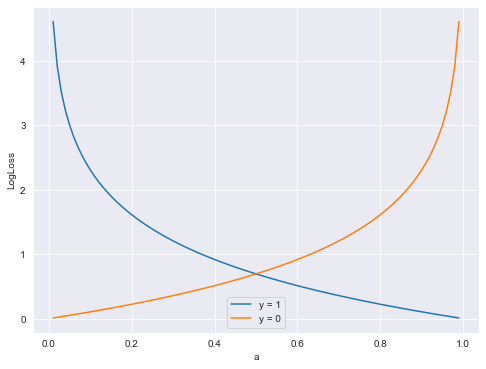

In [ ]:
criterion = torch.nn.BCELoss(reduction='none')
n_values = 99
answers = torch.linspace(0.01, 0.99, n_values)
plt.figure(figsize=(8, 6))
plt.plot(answers, criterion(answers, torch.ones(n_values)), label='y = 1')
plt.plot(answers, criterion(answers, torch.zeros(n_values)), label='y = 0')
plt.ylabel('LogLoss')
plt.xlabel('a')
plt.legend()
plt.show()

Простыми словами, если правильный ответ для объекта `0` и наш алгоритм выдает `0`, то ошибка нулевая. Если же алгоритм отвечает `1`, то ошибка стремится в бесконечность. Обратная ситуация возникает, если правильный ответ `1`.

Обещали не погружать в методы оптимизации, и в методы второго порядка мы погружаться не будем. Используем итеративный градиентный метод первого порядка.
$$W_i_+_1 = W_i - lr*\nabla F(W_i)$$

In [ ]:
W = linear_model.parameters()
optimizer = torch.optim.SGD(W, lr=0.001)

Стандартный цикл обучения градиентными методами выглядит следующим образом

In [ ]:
def train_model(model, criterion, optimizer, x_train, y_train, x_val, y_val, epochs=100):
    losses_train = []
    losses_test = []
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()  # занулим накопившиеся градиенты
        outputs = model(x_train)  # пропустим наши данные через модель
        loss = criterion(torch.squeeze(outputs), y_train)  # вычислим ошибку
        loss.backward()  # вычислим градиенты
        optimizer.step()  # обновим веса

        model.eval()
        with torch.no_grad():
            losses_train.append(loss.item())
            outputs_test = torch.squeeze(model(x_val))
            loss_test = criterion(outputs_test, y_val)
            losses_test.append(loss_test.item())

    return losses_train, losses_test


Одним из самых важных гиперпараметров является темп обучения

100%|██████████| 10000/10000 [00:07<00:00, 1328.73it/s]


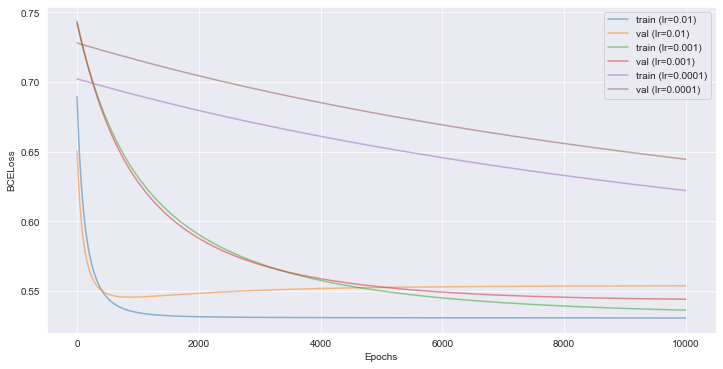

In [ ]:
plt.figure(figsize=(12, 6))
for lr in [0.01, 0.001, 0.0001]:
    linear_model = nn.Sequential(nn.Linear(len(features), 1), nn.Sigmoid())
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(linear_model.parameters(), lr=lr)
    losses_train, losses_test = train_model(linear_model, criterion, optimizer, x_train, y_train, x_val, y_val, 10000)
    plt.plot(losses_train, label=f'train (lr={lr})', alpha=0.5)
    plt.plot(losses_test, label=f'val (lr={lr})', alpha=0.5)
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend()
plt.show()

Помимо этого, можно использовать более продвинутые оптимизаторы (например, Adam), которые обеспечивают более быструю и надежную сходимость градиентного спуска. Подробнее о них можете почитать по [ссылке](https://mlfromscratch.com/optimizers-explained/#/).

<img src="https://mlfromscratch.com/content/images/2019/12/saddle.gif" alt="Drawing" style="width: 600px;"/>

100%|██████████| 10000/10000 [00:08<00:00, 1119.33it/s]


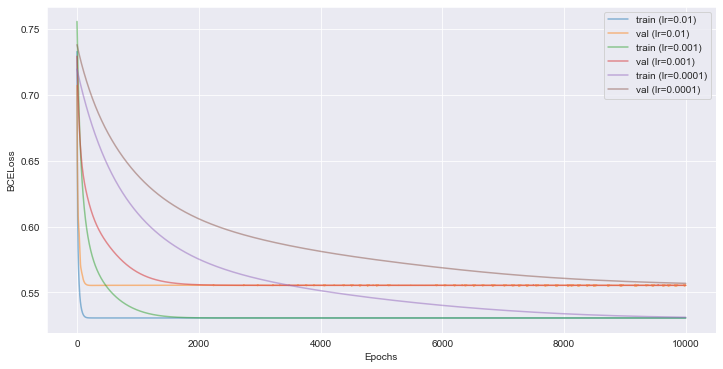

In [ ]:
plt.figure(figsize=(12, 6))
for lr in [0.01, 0.001, 0.0001]:
    linear_model = nn.Sequential(nn.Linear(len(features), 1), nn.Sigmoid())
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(linear_model.parameters(), lr=lr)
    losses_train, losses_test = train_model(linear_model, criterion, optimizer, x_train, y_train, x_val, y_val, 10000)
    plt.plot(losses_train, label=f'train (lr={lr})', alpha=0.5)
    plt.plot(losses_test, label=f'val (lr={lr})', alpha=0.5)
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend()
plt.show()

In [ ]:
def train_and_plot(model, n_epochs):
    plt.figure(figsize=(12, 6))
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses_train, losses_test = train_model(model, criterion, optimizer, x_train, y_train, x_val, y_val, n_epochs)
    plt.plot(losses_train, label=f'train', alpha=0.5)
    plt.plot(losses_test, label=f'val', alpha=0.5)
    plt.xlabel('Epochs')
    plt.ylabel('BCELoss')
    plt.legend()
    plt.show()

Давайте попробуем усложнить нашу модель и добавить в нее промежуточный слой.

100%|██████████| 10000/10000 [00:20<00:00, 484.84it/s]


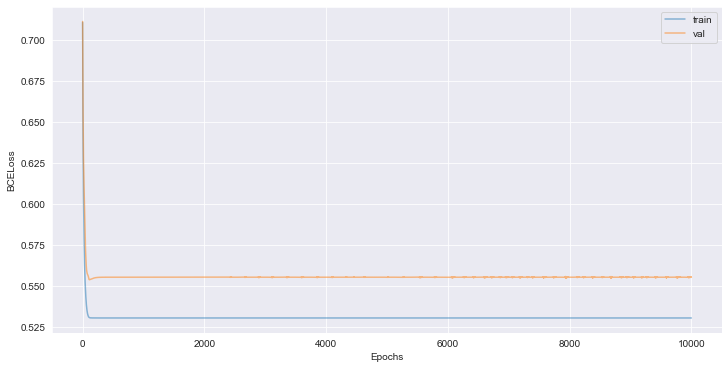

In [ ]:
yet_linear_model = nn.Sequential(nn.Linear(len(features), 100),
                                 # 100 в данном случае это количество нейронов в первом слое
                                 torch.nn.Linear(100, 1),
                                 # второй слой получает 100 выходов с первого слоя (по одному с нейрона)
                                 nn.Sigmoid())
train_and_plot(yet_linear_model, 10000)

Наша модель все еще ведет себя как линейная. Связано это с тем, что линейная комбинация линейных комбинаций это линейная комбинация.
Давайте добавим нелинейность между двумя слоями.

100%|██████████| 1000/1000 [00:02<00:00, 346.64it/s]


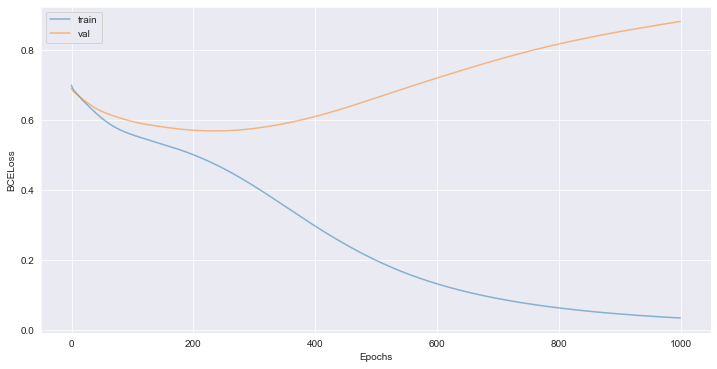

In [ ]:
yet_linear_model = nn.Sequential(nn.Linear(len(features), 100),
                                 nn.Sigmoid(),
                                 torch.nn.Linear(100, 1),
                                 nn.Sigmoid())
train_and_plot(yet_linear_model, 1000)

Можем заметить, что двухслойная нейронная сеть уже способна достаточно быстро выучивать тренировочные данные. Можем предположить, что более глубокая сеть выучит тренировочные данные еще быстрее.

100%|██████████| 1000/1000 [00:27<00:00, 36.33it/s]


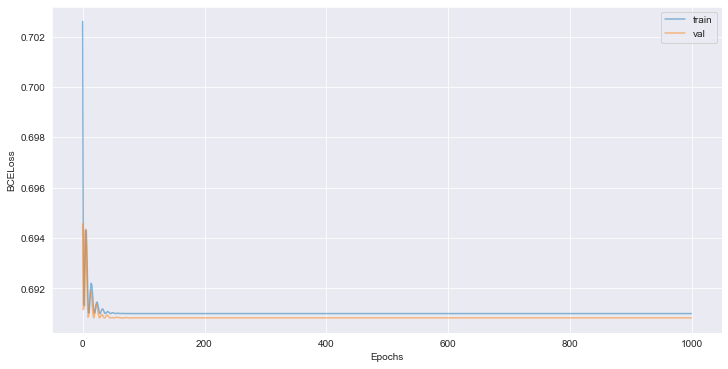

In [ ]:
inter_layers = []
for _ in range(10):
    inter_layers.append(torch.nn.Linear(100, 100))
    inter_layers.append(nn.Sigmoid())

yet_linear_model = nn.Sequential(nn.Linear(len(features), 100),
                                 nn.Sigmoid(),
                                 *inter_layers,
                                 torch.nn.Linear(100, 1),
                                 nn.Sigmoid())
train_and_plot(yet_linear_model, 1000)

Многослойная сеть хуже справилась даже в переобучении на тренировочные данные, чем двухслойная.
Связано это со свойствами выбранной нами функции активации (у сигмоиды и значения и производная положительные во всех точках).
Возьмем в качестве функции активации гиперболический тангенс, который имеет значения от -1 до 1.

100%|██████████| 1000/1000 [00:21<00:00, 46.20it/s]


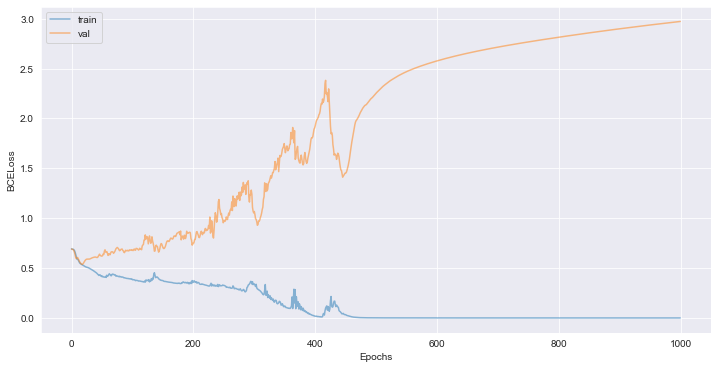

In [ ]:
inter_layers = []
for _ in range(10):
    inter_layers.append(torch.nn.Linear(100, 100))
    inter_layers.append(nn.Tanh())

yet_linear_model = nn.Sequential(nn.Linear(len(features), 100),
                                 nn.Tanh(),
                                 *inter_layers,
                                 torch.nn.Linear(100, 1),
                                 nn.Sigmoid())
train_and_plot(yet_linear_model, 1000)

Теперь модель с трудом, но все же способна выучить тренировочную выборку. Давайте попытаемся еще облегчить ей задачу.

Как вы помните, для линейной модели мы нормализовали входные значения признаков. Но ведь каждый слой нейронной сети это просто преобразование из одного признакового пространства в другое. Воспользуемся слоем `BatchNorm1d`, чтобы нормализовать выходы каждого слоя (данная нормализация работает чуть более хитро, чем StandardScaler() в sklearn).

100%|██████████| 30/30 [00:00<00:00, 33.96it/s]


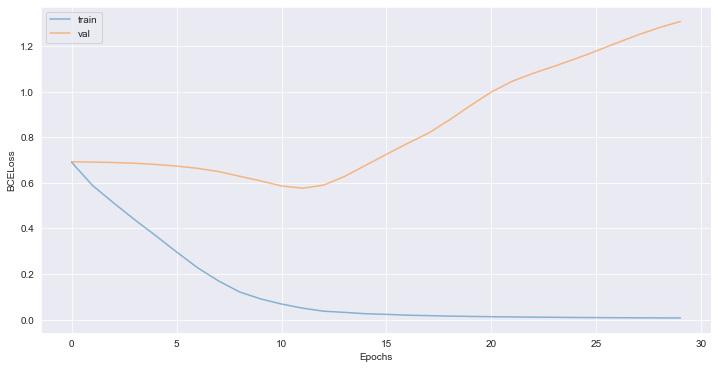

In [ ]:
inter_layers = []
for _ in range(10):
    inter_layers.append(torch.nn.Linear(100, 100))
    inter_layers.append(nn.BatchNorm1d(100))
    inter_layers.append(nn.Tanh())

model = nn.Sequential(nn.Linear(len(features), 100),
                      nn.BatchNorm1d(100),
                      nn.Tanh(),
                      *inter_layers,
                      torch.nn.Linear(100, 1),
                      nn.Sigmoid())
train_and_plot(model, 30)

Можем заметить, что теперь наша модель способна очень быстро выучить тренировочные данные. Однако теперь нам необходимо бороться с переобучением модели. Самый простой способ это уменьшение сложности модели. Помимо этого, можно остановить обучение модели, когда ошибка на валидации начинает возрастать.

100%|██████████| 500/500 [00:01<00:00, 453.20it/s]


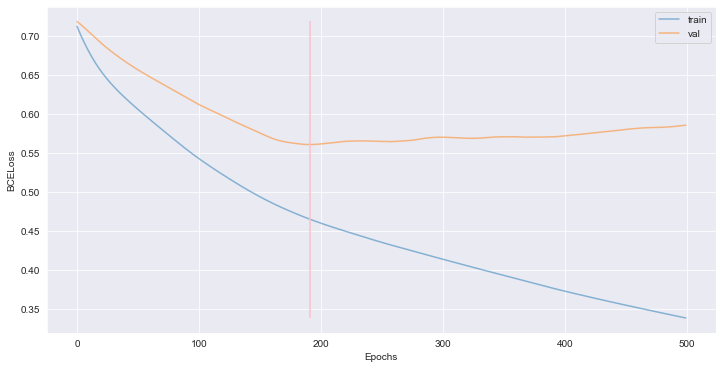

In [ ]:
model = nn.Sequential(nn.Linear(len(features), 10),
                      nn.BatchNorm1d(10),
                      nn.Tanh(),
                      torch.nn.Linear(10, 1),
                      nn.Sigmoid())
plt.figure(figsize=(12, 6))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses_train, losses_test = train_model(model, criterion, optimizer, x_train, y_train, x_val, y_val, 500)
plt.plot(losses_train, label=f'train', alpha=0.5)
plt.plot(losses_test, label=f'val', alpha=0.5)
plt.vlines(np.argmin(losses_test), min(losses_train + losses_test), max(losses_train + losses_test), color='pink')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend()
plt.show()

## Задание
1) Обучите нейросетевую модель для предсказания Сердечной недостаточности.
2) Реализуйте механизм ранней остановки (останавливаем цикл обучения, если n эпох нет улучшения)
3) Подберите оптимальное количество слоев (от 2 до 10), нейронов в каждом слое (от 1 до 128) и [функцию активации](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).
4) Визуализируйте кривую не BCELoss, а Accuracy на каждом шаге обучения.